In [87]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import textwrap

In [88]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'  # STIX fonts are similar to Times New Roman

In [89]:
# path = "../data"
path = "../data_staged"

In [90]:
data = {}
for root, dirs, files in os.walk(path):
    for filename in files:
        if filename.endswith(".csv"):
            path_parts = os.path.normpath(root).split(os.sep)
            if path_parts[-2] not in data:
                data[path_parts[-2]] = {}
            data[path_parts[-2]][os.path.join(root, filename)] = []
            # break

In [91]:
# for function_types in data:
#     for files in data[function_types]:
#         print(files)

Found 80 unique syscalls


Processing function type: func_invc_absent


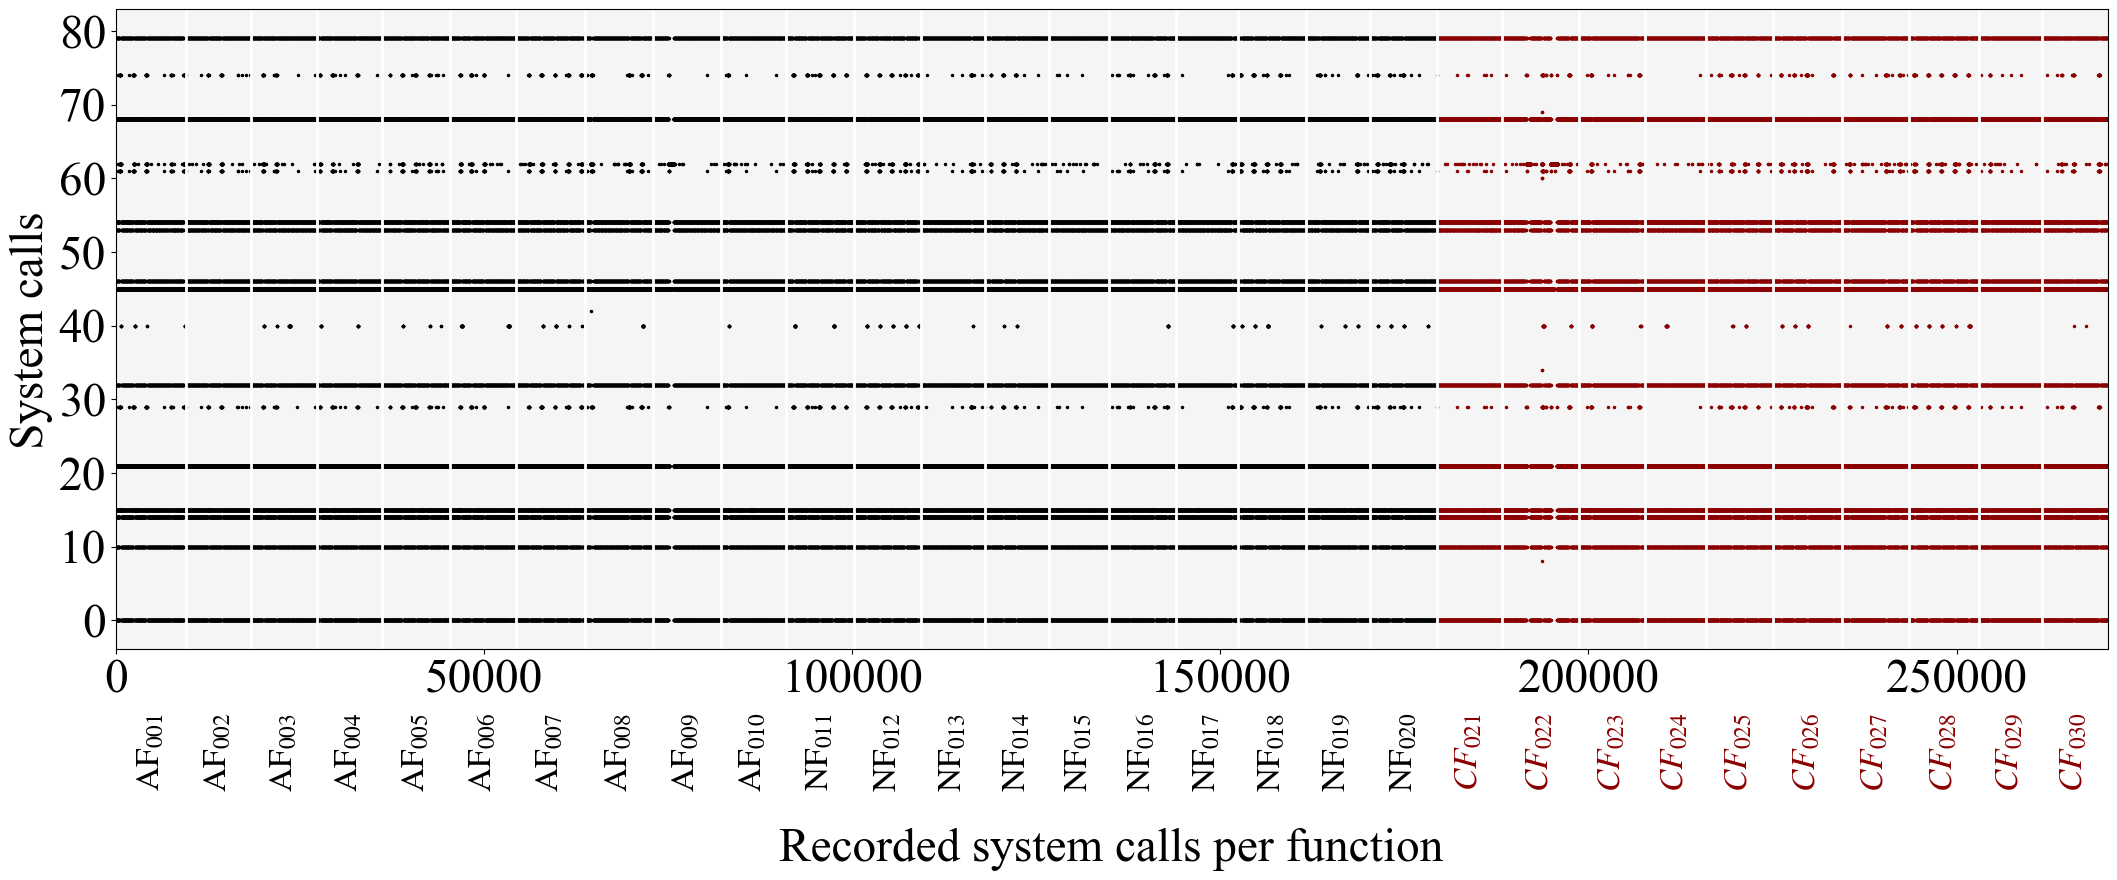

  Total syscalls in func_invc_absent: 270500
  Total files in func_invc_absent: 30

Processing function type: func_invc_present


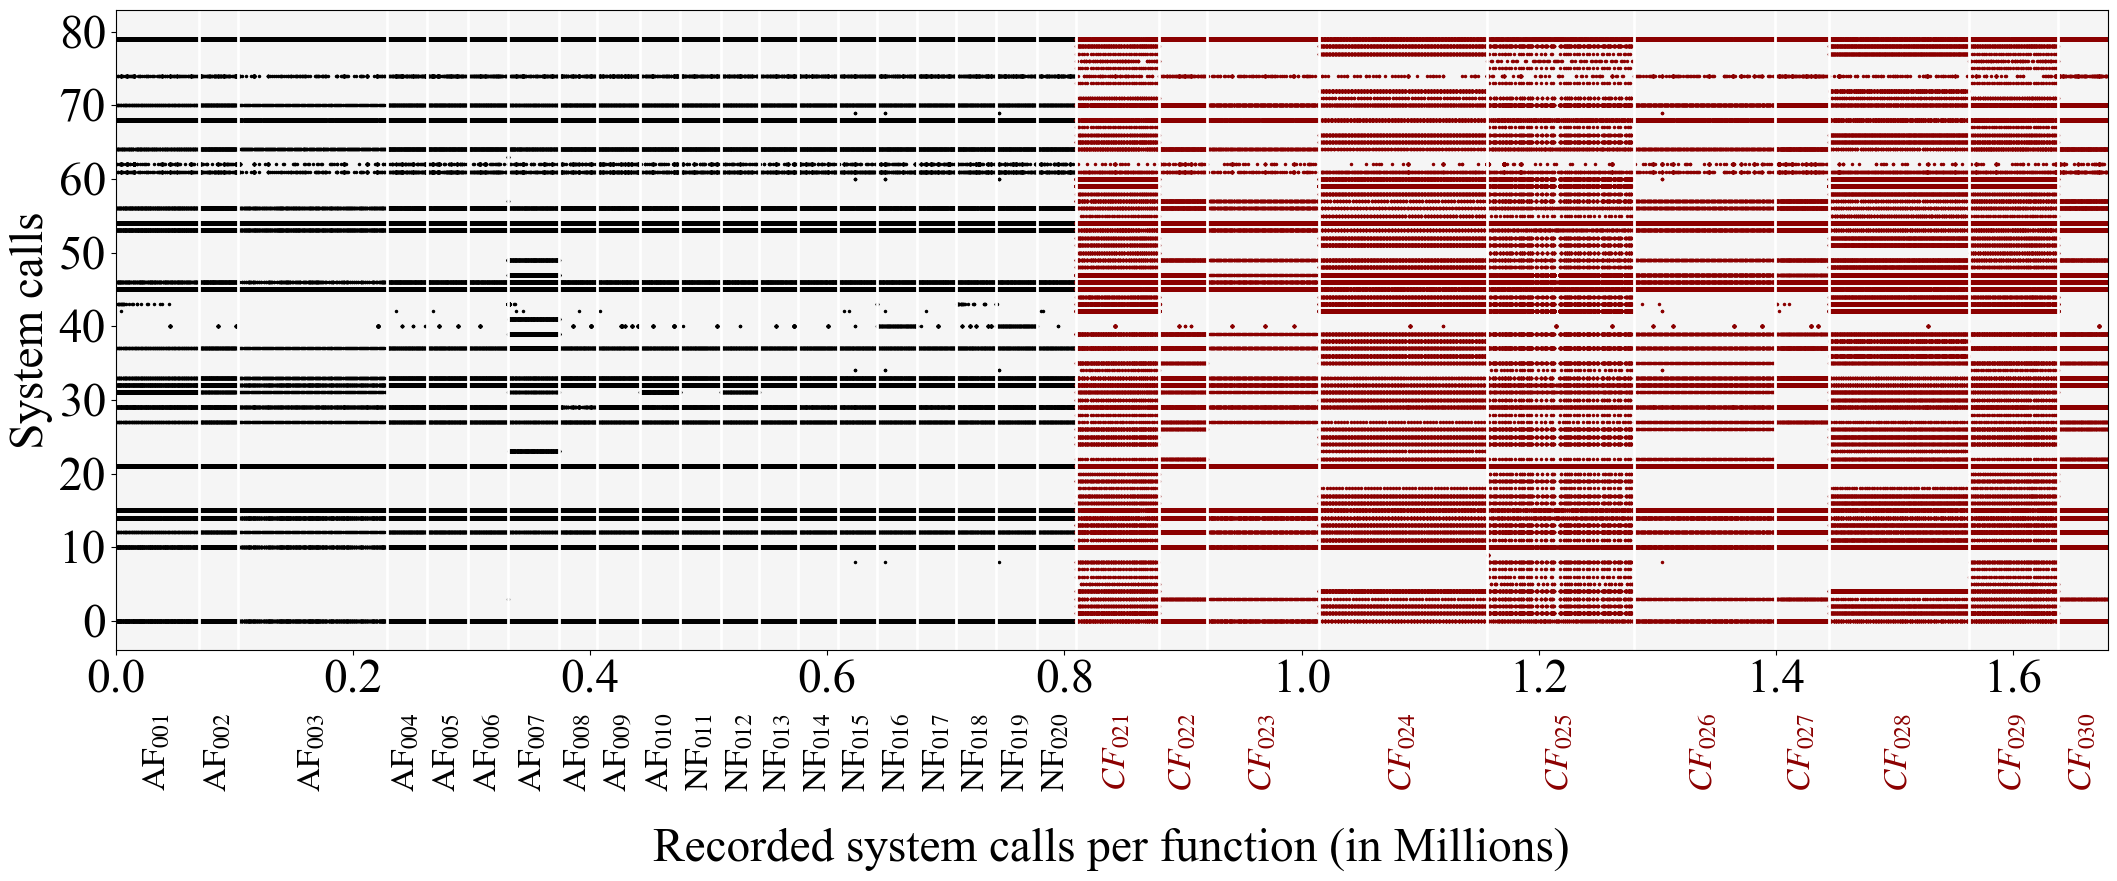

  Total syscalls in func_invc_present: 1679735
  Total files in func_invc_present: 30


In [92]:
# Helper function to wrap long syscall names
font_size = 34
font_size_small = 24
def wrap_label(label, max_chars=15):
    """Wrap long labels into multiple lines"""
    return '\n'.join(textwrap.wrap(label, max_chars))

# Collect all unique syscalls from all files to maintain consistent y-axis
all_syscalls = set()
for function_type in data:
    for filepath in data[function_type]:
        try:
            df = pd.read_csv(filepath)
            all_syscalls.update(df['syscall'].unique())
        except Exception as e:
            print(f"Error reading {filepath}: {e}")

unique_syscalls = sorted(list(all_syscalls))
syscall_to_y = {syscall: idx for idx, syscall in enumerate(unique_syscalls)}

# Wrap syscall labels for display
wrapped_syscalls = [wrap_label(syscall) for syscall in unique_syscalls]

print(f"Found {len(unique_syscalls)} unique syscalls\n")

# Create one figure per function type
for function_type in sorted(data.keys()):
    print(f"\n{'='*80}")
    print(f"Processing function type: {function_type}")
    print(f"{'='*80}")
    
    # Larger figure to accommodate horizontal y-axis labels
    plt.figure(figsize=(24, 8))
    
    cumulative_x = 0
    file_boundaries = []
    file_labels = []
    
    # Plot all files for this function type sequentially
    for filepath in sorted(data[function_type].keys()):
        try:
            # Read syscall data
            df = pd.read_csv(filepath)
            
            # Map syscalls to y-axis positions
            x_positions = [cumulative_x + i for i in range(len(df))]
            y_positions = [syscall_to_y[syscall] for syscall in df['syscall']]
            
            # Determine if this is a CF (compromised function) file
            filename = os.path.basename(filepath)
            is_cf = filename[4:6] == 'CF'
            
            # Plot points: black for normal, dark red/maroon for CF (academic color)
            point_color = '#8B0000' if is_cf else 'black'  # Dark red for CF
            points = plt.plot(x_positions, y_positions, 'o', markersize=1.5, alpha=1.0, zorder=2, color=point_color)[0]
            points.set_rasterized(True)
            
            # Store file information for annotations
            file_labels.append(filename)
            file_boundaries.append((cumulative_x, cumulative_x + len(df)))
            
            # Add vertical line to separate files (solid white, thicker for visibility)
            if cumulative_x > 0:
                plt.axvline(x=cumulative_x, color='white', linestyle='-', linewidth=2, alpha=1.0)
                # plt.axvline(x=cumulative_x, color='gray', linestyle='-', linewidth=1, alpha=1.0)
            
            # Update cumulative position for next file
            cumulative_x += len(df)
            
            # print(f"  Plotted {len(df)} syscalls from {filename}")
            
        except Exception as e:
            print(f"  Error processing {filepath}: {e}")
    
    # Configure plot with horizontal y-axis labels
    # plt.yticks(range(len(unique_syscalls)), wrapped_syscalls, fontsize=7, rotation=0, ha='right')
    plt.yticks(fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.xlim(0, cumulative_x)  # Remove white space on left and right
    # plt.ylim(-1, len(unique_syscalls))  # Remove white space on top and bottom
    
    # Format x-axis: use millions format only when values are large (>1M)
    ax = plt.gca()
    # Add darker gray background with grid
    ax.set_facecolor('#f5f5f5')  # Use a much lighter gray for the background
    # ax.grid(True, color='white', linestyle='-', linewidth=0.8, alpha=0.8)
    if cumulative_x > 1e6:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
        plt.xlabel('Recorded system calls per function (in Millions)', fontsize=font_size, labelpad=90)
    else:
        plt.xlabel('Recorded system calls per function', fontsize=font_size, labelpad=90)
    plt.ylabel('System calls', fontsize=font_size)
    # plt.title(f'System Calls - {function_type}', fontsize=14, fontweight='bold')
    
    # Add file labels below the x-axis (without background)
    # Use fixed y position relative to axis for consistent label alignment
    y_min, y_max = ax.get_ylim()
    y_pos_below = y_min - (y_max - y_min) * 0.16  # Fixed position below x-axis
    for i, (start, end) in enumerate(file_boundaries):
        mid_point = (start + end) / 2
        num_sequences = end - start
        # Extract digits (first 3 chars) and code (chars 4-5) from filename like "001_AF_logs_..."
        digits = file_labels[i][:3]
        code = file_labels[i][4:6]
        # Format as "CF₀₀₁ (1234)" with bold+italic CFxxx for CF labels, count not bold
        if code == 'CF':
            # Bold+italic CFxxx in dark red, count in regular weight
            label_text = f"$\\mathbf{{\\mathit{{{code}}}}}_{{\\mathbf{{\\mathit{{{digits}}}}}}}$"
            # label_text = f"$\\mathbf{{\\mathit{{{code}}}}}_{{\\mathbf{{\\mathit{{{digits}}}}}}}$ ({num_sequences})"
            label_color = '#8B0000'  # Dark red to match points
        else:
            label_text = f"$\\mathrm{{{code}}}_{{\\mathrm{{{digits}}}}}$"
            # label_text = f"$\\mathsf{{{code}}}_{{\\mathsf{{{digits}}}}}$ ({num_sequences})"
            label_color = 'black'
        plt.text(mid_point, y_pos_below, label_text, 
                 ha='center', va='center', fontsize=font_size_small, rotation=90, color=label_color)
    
    # Adjust layout to accommodate labels below x-axis
    plt.subplots_adjust(left=0.15, right=0.98, top=0.95, bottom=0.15)
    # plt.savefig(f"./figures/combined_{function_type}.png", dpi=600, bbox_inches='tight')
    plt.savefig(f"./figures/combined_{function_type}.pdf", bbox_inches='tight')
    plt.show()
    
    print(f"  Total syscalls in {function_type}: {cumulative_x}")
    print(f"  Total files in {function_type}: {len(file_boundaries)}")